In [34]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import requests
import re
from multiprocessing import Queue
import networkx as nx
import musicbrainzngs as mb 
import pickle

CLIENT_ID = "3a533c6fd3434a29a09896712d5c19bd"
CLIENT_SECRET = "65f9ad113dd54f6091cee7aa5498568b"
mb.set_useragent('redes_complejas', 0.1) 

def conseguir_id(artista):
    # POST donde le pasamos las clave de la app
    response = requests.post('https://accounts.spotify.com/api/token', data = {'grant_type': 'client_credentials', 'client_id': CLIENT_ID, 'client_secret': CLIENT_SECRET})
    # Guardamos el bearer token para usarlo en las peticiones de la API
    access_token = response.json()['access_token']
    headers = {'Authorization': 'Bearer {}'.format(access_token), 'Accept': 'application/json', 'Content-Type': 'application/json'}

    """
    Recibe
        artista: Nombre del artista del cual se quiere su ID
    Devuelve:
        id: La ID del artista
    """
    # End point para obtener los audio features. Esto se saca de la referencia de la documentación
    url = 'https://api.spotify.com/v1/search'

    # Búsqueda. Acá sí hay que pasarselo como parámetros
    params = {'q': f"{artista}", 'type': 'artist', 'limit': '2'}

    # En este caso no lleva ningún parámetro, el id de la canción va directamente en el url
    response = requests.get(url, params = params, headers = headers)

    # Vemos el json de la respuesta
    json_data = response.json()
    
    # Con la siguiente lista conseguimos el ID del primer resultado de la busqueda (creo)
    id = json_data["artists"]["items"][0]["id"]

    return id

def es_argentino_y_genero(nombre_artista): #devuelve true or false nada mas, si queremos mas cosas cambiarlo
    # Metemos a Argentina en la lista de provincias por las dudas ya que hay artistas que lo tienen
    es_arg = False
    genero = "NA"
    lista_provincias = ["Argentina","Buenos Aires", "Catamarca", "Chaco", "Chubut", "Córdoba", "Corrientes", "Entre Ríos", "Formosa", "Jujuy", "La Pampa", "La Rioja", "Mendoza", "Misiones", "Neuquén", "Río Negro", "Salta", "San Juan", "San Luis", "Santa Cruz", "Santa Fe", "Santiago del Estero", "Tierra del Fuego", "Tucumán"]
    data = mb.search_artists(artist = nombre_artista, limit= 1)
    if data["artist-count"] != 0: #SI ENCUENTRA EL ARTISTA EN MUSIC BRANDZ
        if "country" in data["artist-list"][0]:
            pais = data["artist-list"][0]["country"]
            if pais == 'AR':
                es_arg = True
        # Comprobamos las provincias si no está el país
        elif "begin-area" in data["artist-list"][0]:
            provincia = data["artist-list"][0]["begin-area"]["name"]
            if provincia in lista_provincias:
                es_arg = True
        elif "area" in data["artist-list"][0]:
            provincia = data["artist-list"][0]["area"]["name"]
            if provincia in lista_provincias:
                es_arg = True
        if "gender" in data["artist-list"][0]:
            genero = data["artist-list"][0]["gender"]

          
    return es_arg, genero

# En la siguiente línea se define de donde se saca toda la info, como si este fuera el paquete
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id = CLIENT_ID, client_secret=CLIENT_SECRET))

q = Queue()

def red_colaboradores_artista(nombre_artista, G):
    lista_cuadrivectores = []
    albums_revisados = []
    lista_colaboradores = []
    # Uri es como el id del artista pero para spotipy
    uri = "spotify:artist:" + conseguir_id(nombre_artista)
    # Conseguimos los albumes del artista
    results = sp.artist_albums(uri, album_type='album,single', country='AR')
    albums = results['items']

    # No se que hace bien todavia 
    while results['next']:
        # Depaginate
        results = sp.next(results)
        albums.extend(results['items'])

    # Hacemos un filtro a los albumes para que sean únicos
    real_albums = dict()

    for album in albums:
        
        # Strip extraneous characters
        name = re.sub(r'\([^)]*\)|\[[^)]*\]', '', album['name']) # remove (Deluxe edition) and [Feat. asdf] tags
        name = re.sub(r'\W','', name).lower().strip() # remove all non-alphanumerical characters
        if name not in real_albums:
            # print('Adding ' + name)
            real_albums[name] = album
            real_albums[name+"_fecha"] = album["release_date"]

    # Ciclamos sobre los albumes que son únicos
    for album in real_albums:
        # Chequeamos que no hayamos revisado el album
        if album not in albums_revisados:
            # Mark album as analyzed
            albums_revisados.append(album)
            # print('\tAlbum: ' + real_albums[album]['name'])

            # Obtenemos las canciones del album
            results = sp.album_tracks(real_albums[album]['id'])
            canciones = results['items']
            while results['next']:
                results = sp.next(results)
                canciones.extend(results['items'])

            # Recorremos las canciones
            for cancion in canciones:
                # Recorremos los artistas de la canción
                for artist in cancion['artists']:
                    # Chequeamos que no tengan igual uri
                    if artist['uri'] != uri:
                        # print('\t\t' + artist['name'])
                        # La siguiente línea no la entiendo bien, pero creo que lo que hace es el time.sleep que haciamos pero mejor
                        q.put(artist['uri'])
                        
                        es_argentino, genero_colaborador = es_argentino_y_genero(artist['name'])


                        if artist['uri'] not in G and es_argentino:
                            # Get detailed description of artist and create node
                            artist = sp.artist(artist['uri'])
                                # print(artist)
                            G.add_node(artist['name'], id=artist['uri'], popularidad=artist['popularity'], generos_musicales = artist['genres'], genero = genero_colaborador)
                            lista_colaboradores.append(artist['name'])
                            # # Try adding artist's image
                            # if len(artist['images']) > 0:
                            #     G.node[artist['uri']]['image_url'] = artist['images'][0]['url']
                            # else:
                            #     G.node[artist['uri']]['image_url'] = "https://developer.spotify.com/wp-content/uploads/2016/07/icon1@2x.png"
                        # Count how many collaborations
                            try:
                                G[artist['name']][nombre_artista]['freq'] += 1
                            except KeyError:
                                G.add_edge(artist['name'], nombre_artista, freq=1)
    return lista_colaboradores

def crear_red_ego(nombre_artista,G):
    lista_colaboradores = red_colaboradores_artista(nombre_artista, G)
    # for colaborador in lista_colaboradores:
    #     lista_colaborades_2 = red_colaboradores_artista(colaborador, G)
    #     for colaborador_2 in lista_colaboradores_2:
    #         if colaborador_2 not in lista_colaboradores:
    #             lista_colaboradores.append(colaborador_2)
        
    return G


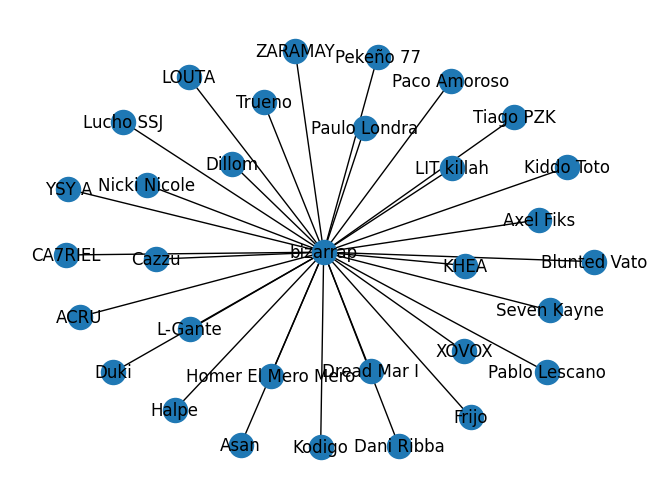

In [2]:
red = crear_red_ego('bizarrap')
nx.draw(red, with_labels = True)

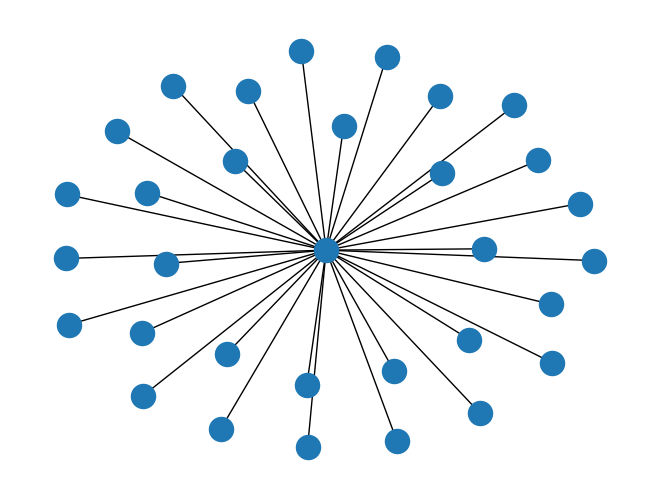

In [11]:
G = nx.MultiGraph()
artista_central = "Bizarrap"
lista_artistas = [artista_central]

i = 0
while i < 50:
    

    i += 1

In [85]:
def crear_red_ego(nombre_artista, max_iteraciones):

    # Definimos un multigrafo
    G = nx.MultiGraph()

    # Artists that have been examined
    lista_artistas = [nombre_artista]

    # Albums that have been examined
    albums_revisados = []

    i = 0
    while i < max_iteraciones:

        # Uri es como el id del artista pero para spotipy
        uri = "spotify:artist:" + conseguir_id(lista_artistas[i])
        # Conseguimos los albumes del artista
        results = sp.artist_albums(uri, album_type='album,single', country='AR') # Esto algo filtra tambien
        albums = results['items']

        # No se que hace bien todavia 
        while results['next']:
            # Depaginate
            results = sp.next(results)
            albums.extend(results['items'])

       
        real_albums = dict()
        # Hacemos un filtro a los albumes para que sean únicos
        for album in albums:
            # Strip extraneous characters
            name = re.sub(r'\([^)]*\)|\[[^)]*\]', '', album['name']) # remove (Deluxe edition) and [Feat. asdf] tags
            name = re.sub(r'\W','', name).lower().strip() # remove all non-alphanumerical characters
            if name not in real_albums:
                # print('Adding ' + name)
                real_albums[name] = album
             
              
        # Ciclamos sobre los albumes que son únicos
        for album in real_albums:
            # album es un string con el nombre del album
            fecha_album = real_albums[album]['release_date']
            # Chequeamos que no hayamos revisado el album
            if album not in albums_revisados:
                # Mark album as analyzed
                albums_revisados.append(album)
                # print('\tAlbum: ' + real_albums[album]['name'])

                # Obtenemos las canciones del album
                results = sp.album_tracks(real_albums[album]['id'])
                canciones = results['items']
                while results['next']:
                    results = sp.next(results)
                    canciones.extend(results['items'])

                # Recorremos las canciones
                for cancion in canciones:
                    # Recorremos los artistas de la canción
                    for artist in cancion['artists']:
                        # Chequeamos que no tengan igual uri
                        if artist['uri'] != uri:
                            # print('\t\t' + artist['name'])
                            # La siguiente línea no la entiendo bien, pero creo que lo que hace es el time.sleep que haciamos pero mejor
                            q.put(artist['uri'])
                            
                            es_argentino, genero_colaborador = es_argentino_y_genero(artist['name'])

                            if artist['uri'] not in G and es_argentino:
                                # Get detailed description of artist and create node
                                artist = sp.artist(artist['uri'])
                                # print(artist)
                                # Agregamos atributos al nodo
                                G.add_node(artist['name'], id=artist['uri'], popularidad=artist['popularity'], generos_musicales = artist['genres'], genero = genero_colaborador)
                                lista_artistas.append(artist['name'])
                                # # Try adding artist's image
                                # if len(artist['images']) > 0:
                                #     G.node[artist['uri']]['image_url'] = artist['images'][0]['url']
                                # else:
                                #     G.node[artist['uri']]['image_url'] = "https://developer.spotify.com/wp-content/uploads/2016/07/icon1@2x.png"
                            # Count how many collaborations
                                # Siempre agrego enlace ya que tiene en cuenta el tiempo
                                G.add_edge(artist['name'], nombre_artista, fecha = fecha_album)
        i += 1

    # Guardo la lista para recorrerla si lo cortamos, y el grafo q es lo que importa porque esta toda la info
    return lista_artistas, G

Ejemplo de como se agregan los multienlaces

In [42]:
G = nx.MultiGraph()

# Funciona con numeros y strings por igual
G.add_edge("jorge",2, color = "12")
G.add_edge("jorge",2, color = 'messi')

G["jorge"][2]

AtlasView({0: {'color': '12'}, 1: {'color': 'messi'}})

In [86]:
lista_artistas, red = crear_red_ego("bizarrap",1)

In [87]:
red["bizarrap"]["Duki"]

AtlasView({0: {'fecha': '2021-12-01'}, 1: {'fecha': '2021-10-14'}, 2: {'fecha': '2021-07-28'}, 3: {'fecha': '2019-12-13'}})

In [88]:
red.degree()

MultiDegreeView({'Paulo Londra': 1, 'bizarrap': 48, 'Trueno': 4, 'L-Gante': 2, 'Pablo Lescano': 1, 'Tiago PZK': 1, 'Duki': 4, 'Nicki Nicole': 3, 'YSY A': 2, 'Dread Mar I': 1, 'Asan': 1, 'ACRU': 1, 'KHEA': 1, 'Seven Kayne': 1, 'Cazzu': 1, 'ZARAMAY': 1, 'Homer El Mero Mero': 1, 'LIT killah': 2, 'Lucho SSJ': 1, 'Dani Ribba': 2, 'Pekeño 77': 2, 'LOUTA': 1, 'Frijo': 2, 'CA7RIEL': 1, 'Kiddo Toto': 1, 'Dillom': 1, 'Kodigo': 3, 'Blunted Vato': 1, 'Paco Amoroso': 1, 'Axel Fiks': 1, 'Halpe': 2, 'XOVOX': 1})

Para guardar la red

In [ ]:
pickle.dump(lista_artistas, open('lista artistas argentinos', 'wb'))
nx.write_gexf(red, "bizarrap_iteracion_tanto.gexf")